In [18]:
# STEP 1: Mount Google Drive (if using Google Colab)
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [19]:
# STEP 2: Import Required Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score


# STEP 3: Load the Dataset
file_path = '/content/drive/My Drive/GOOG.csv'  # Replace with your path if needed
df = pd.read_csv(file_path)

# Display the first few rows and check column names
print(df.head())
print(df.columns)


In [24]:
# STEP 4: Preprocess the Data
# Convert date column to datetime
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values('date')

# Use only 'close' price for prediction and use lagged values as features
df['close_next'] = df['close'].shift(-1)  # This is the target: next day's price

# Drop last row (target is NaN)
df = df[:-1]


# Features: use Open, High, Low, Close, Volume
# Check the actual column names in your DataFrame (e.g., print(df.columns))
# Adjust the features list to match the actual column names if needed
# If the column names have different cases (e.g., 'open' instead of 'Open'),
# adjust accordingly.
features = ['open', 'high', 'low', 'close', 'volume']
# Example: If your columns are lowercase, use this:
# features = ['open', 'high', 'low', 'close', 'volume']

X = df[features]
y = df['close_next'] # The target variable should match the created column from above


In [27]:
# STEP 5: Split Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)


In [30]:
# STEP 6: Train Machine Learning Models

# Linear Regression
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Random Forest Regressor
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)


RandomForestRegressor(random_state=42)

In [33]:
# STEP 7: Make Predictions
lr_preds = lr_model.predict(X_test)
rf_preds = rf_model.predict(X_test)


In [34]:
# STEP 8: Evaluate Models
print("📈 Linear Regression")
print("RMSE:", np.sqrt(mean_squared_error(y_test, lr_preds)))
print("R2 Score:", r2_score(y_test, lr_preds))

print("\n🌳 Random Forest Regressor")
print("RMSE:", np.sqrt(mean_squared_error(y_test, rf_preds)))
print("R2 Score:", r2_score(y_test, rf_preds))


📈 Linear Regression
RMSE: 32.011202324108744
R2 Score: 0.9901562630328486

🌳 Random Forest Regressor
RMSE: 459.85551851548564
R2 Score: -1.0314158330761392


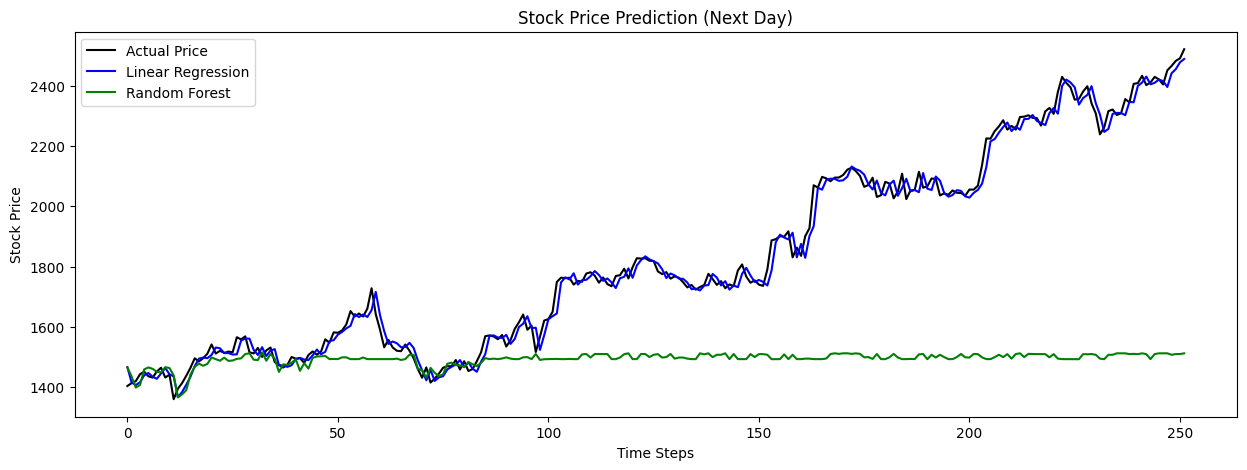

In [35]:
# STEP 9: Visualize Predictions
plt.figure(figsize=(15,5))
plt.plot(y_test.values, label='Actual Price', color='black')
plt.plot(lr_preds, label='Linear Regression', color='blue')
plt.plot(rf_preds, label='Random Forest', color='green')
plt.title('Stock Price Prediction (Next Day)')
plt.xlabel('Time Steps')
plt.ylabel('Stock Price')
plt.legend()
plt.show()


In [37]:
# STEP 10: Predict Future N Days (e.g., 7 days into the future)
N_DAYS = 7

# Start with the last known row of features
last_known_row = df[features].iloc[-1].copy()

# Create empty list to store future predictions
future_predictions = []

for i in range(N_DAYS):
    # Convert row to 2D array as expected by model
    input_features = np.array(last_known_row).reshape(1, -1)

    # Predict next day's price
    next_close = rf_model.predict(input_features)[0]
    future_predictions.append(next_close)

    # Update row: shift features assuming market trend continues
    last_known_row['open'] = last_known_row['close']
    last_known_row['high'] = max(last_known_row['high'], next_close)
    last_known_row['low'] = min(last_known_row['low'], next_close)
    last_known_row['close'] = next_close
    last_known_row['volume'] = last_known_row['volume']  # Keep volume same or use avg if needed

# Print predictions
print(f"\n📅 Predicted closing prices for next {N_DAYS} days:")
for i, price in enumerate(future_predictions, 1):
    print(f"Day {i}: {price:.2f}")



📅 Predicted closing prices for next 7 days:
Day 1: 1512.23
Day 2: 1509.57
Day 3: 1514.26
Day 4: 1513.26
Day 5: 1514.57
Day 6: 1514.32
Day 7: 1514.57


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/

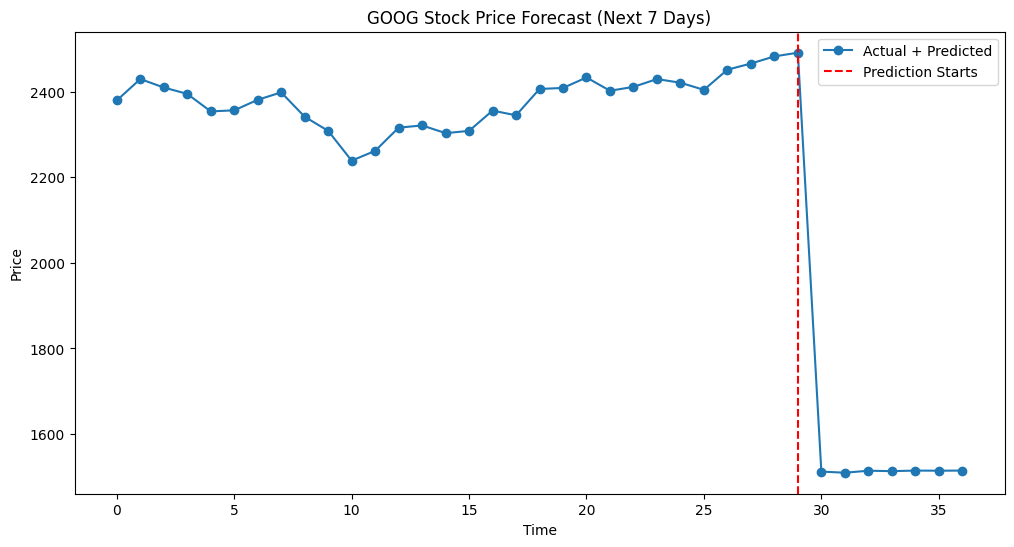

In [39]:
# Plot last 30 actual closing prices and predicted next 7
plt.figure(figsize=(12,6))
recent_closes = df['close'].tail(30).tolist()
full_series = recent_closes + future_predictions
plt.plot(range(len(full_series)), full_series, marker='o', label='Actual + Predicted')
plt.axvline(x=29, color='red', linestyle='--', label='Prediction Starts')
plt.title(f'GOOG Stock Price Forecast (Next {N_DAYS} Days)')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()